### Loading dataset, model and checkpoint


In [7]:

import sys
sys.path.append('../Code')

from Data.Dataloaders import Load_contrastive_dataset
from Model.Load_model import Model, create_mlp

import torch

train_dataset, val_dataset, classes = Load_contrastive_dataset("../Datasets/Pretraining", "chembl_25_subset", "smiles", batch_size = 8)
print ("datasets were sucssesfully loaded")

model = Model("ViT-B/16").to("cuda")
print ("model was sucssesfully loaded")

checkpoint = torch.load('../Checkpoints/MoleCLIP/MoleCLIP - Primary.pth', map_location=torch.device("cpu"), weights_only=False)
checkpoint['model'] = {key: value for key, value in checkpoint['model'].items() if 'cls' not in key and 'clip_model' not in key}

model.load_state_dict(checkpoint['model'])


datasets were sucssesfully loaded
model was sucssesfully loaded


<All keys matched successfully>

### Running model and save embeddings

In [ ]:
import matplotlib.pyplot as plt

dataset_path = "../Datasets/Pretraining/chembl_25_subset" # change dataset path when needed

if not os.path.isdir(f"{dataset_path}/embeddings"): #change dataset path where needed
    os.mkdir(f"{dataset_path}/embeddings")  

all_embeddings = torch.zeros([1, 512]).to("cuda")
all_embeddings_aug = torch.zeros([1, 512]).to("cuda")
all_classes = torch.zeros([1]).to("cuda")

with torch.no_grad():

    for data in [iter(train_dataset)]:
        for it in tqdm(range(len(data))):

            image1, image2, cls1_labels = next(data)

            image1_features = model.model_image(image1).float()
            image2_features = model.model_image(image2).float()

            all_embeddings = torch.cat([all_embeddings, image1_features], dim = 0)
            all_embeddings_aug = torch.cat([all_embeddings_aug, image2_features], dim = 0)
            all_classes = torch.cat([all_classes, cls1_labels], dim = 0)

    torch.save(all_embeddings[1:], f"{dataset_path}/embeddings/embeddings_chembl.pt")
    torch.save(all_embeddings_aug[1:], f"{dataset_path}/embeddings/embeddings_chembl_aug.pt")
    torch.save(all_classes[1:], f"{dataset_path}/embeddings/classes_chembl.pt")


### Visualize to evaluate contrastive task

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np

embeddings = torch.load(f"{dataset_path}/embeddings/embeddings_chembl.pt")
embeddings_aug = torch.load(f"{dataset_path}/embeddings/embeddings_chembl_aug.pt")

all_embeddings = torch.cat([embeddings, embeddings_aug], dim = 0).cpu().detach().numpy()

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

colors = [
    "#1f77b4",  
    "#ff7f0e",  
    "#2ca02c",  
    "#d62728",  
    "#9467bd",  
    "#8c564b",  
    "#e377c2",  
    "#fdfd96",  
    "#bcbd22",  
    "#17becf"   
]

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], color = "gray", alpha=0.5, s=5)

n_samples = int(embeddings_2d.shape[0]/2)

for i in range(10):
    plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], color=colors[i], s=60, edgecolors='gray')
    plt.scatter(embeddings_2d[n_samples+i, 0], embeddings_2d[n_samples+i, 1], color=colors[i], s=60, edgecolors='gray')




### Visualize to evaluate classification task

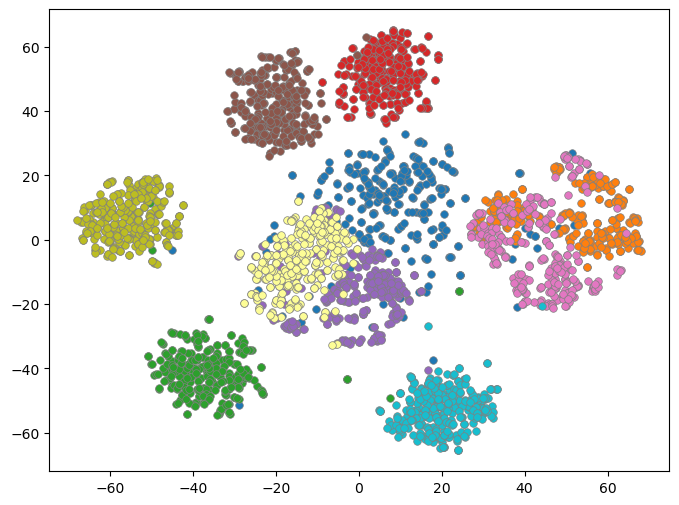

In [ ]:
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score

embeddings = torch.load("../Datasets/Pretraining/chembl_25_subset/embeddings_chembl2.pt").cpu().detach().numpy()
classes = torch.load("../Datasets/Pretraining/chembl_25_subset/labels_chembl2.pt").cpu().detach().numpy()

colors = [
    "#1f77b4",  
    "#ff7f0e",  
    "#2ca02c",  
    "#d62728",  
    "#9467bd",  
    "#8c564b",  
    "#e377c2",  
    "#fdfd96",  
    "#bcbd22",  
    "#17becf"   
]

tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))

for i in range(10): #number of classes
    positions = [j for j in range (len(classes)) if classes[j]==i]
    plt.scatter(embeddings_2d[positions, 0], embeddings_2d[positions, 1], color=colors[i], s=30, edgecolors='gray', linewidths = 0.5)

plt.show()

